In [1]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [2]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "titel" 
FROM scraper_auto  
WHERE prijs < 15000 AND prijs > 900
''', conn)
df = df_raw.dropna()
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine
count,1079.000000,1.079000e+03,1079.000000,1079.000000,1079.000000,1079.000000
mean,2009.854495,1.635608e+05,83.530120,3794.549583,0.977757,0.590361
std,2.974561,9.953461e+04,13.244972,2326.822897,0.147541,0.491995
min,2005.000000,7.183000e+03,51.000000,944.000000,0.000000,0.000000
25%,2007.000000,1.148100e+05,77.000000,2350.000000,1.000000,0.000000
50%,2010.000000,1.653300e+05,84.000000,2950.000000,1.000000,1.000000
75%,2011.000000,2.064545e+05,86.000000,4450.000000,1.000000,1.000000
max,2018.000000,2.625966e+06,180.000000,13900.000000,1.000000,1.000000


In [3]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,titel
1032,2011,240000.0,84,1.0,0,Fiat Punto1.3 MJet Actual
656,2007,169925.0,77,0.0,1,Fiat Grande Punto 1.4 DYNAMIC AUTOMAAT / AIRCO...
788,2015,78732.0,101,1.0,1,Fiat Punto 5drs. 0.9TwinAir 101pk Lounge (Pano...
124,2009,145369.0,78,1.0,1,Fiat Grande Punto 1.4 Active /NIEUWE A.P.K/AIR...
485,2007,265000.0,95,1.0,1,Fiat Punto1.416V Sport
...,...,...,...,...,...,...
298,2013,69981.0,86,1.0,1,Fiat Punto 0.9 TwinAir 85PK 5DRS LOUNGE ECC LE...
511,2007,170933.0,65,1.0,1,Fiat Grande Punto1.2 Active / Airco
785,2015,79505.0,101,1.0,1,Fiat Punto Evo 0.9 TwinAir Street YB30211 | De...
590,2011,221485.0,84,1.0,0,Fiat PuntoEVO 1.3 MJet Dynamic


In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
        ('text',  CountVectorizer(), 'titel')
    ],
    remainder='passthrough')

In [9]:
pipelines = []
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('LR', DecisionTreeRegressor())])))
pipelines.append(('Lasso                      ', Pipeline([('preprocessor', preprocessor),('LASSO', Lasso())])))
pipelines.append(('ElasticNet                 ', Pipeline([('preprocessor', preprocessor),('EN', ElasticNet())])))
pipelines.append(('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('KNN', KNeighborsRegressor())])))
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('CART', DecisionTreeRegressor())])))
pipelines.append(('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %i (%i)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

DecisionTreeRegressor      : 630 (69)
Lasso                      : 504 (49)
ElasticNet                 : 636 (58)
KNeighborsRegressor        : 601 (61)
DecisionTreeRegressor      : 630 (72)
GradientBoostingRegressor  : 471 (49)


In [10]:
param_grid = {
    'preprocessor__numeric__imputer__strategy': ['mean', 'median', 'constant'],
    'preprocessor__text__ngram_range': [(1,1), (1,2), (1,3)],
#     'classifier__loss': ['ls', 'lad', 'huber', 'quantile'],
#     'classifier__learning_rate': np.arange(0, 0.5, 0.1)
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor(loss='huber', learning_rate=0.1))
])

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 530.290


{'preprocessor__numeric__imputer__strategy': 'constant',
 'preprocessor__text__ngram_range': (1, 1)}

In [11]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 530
Mean squared error:	 769536


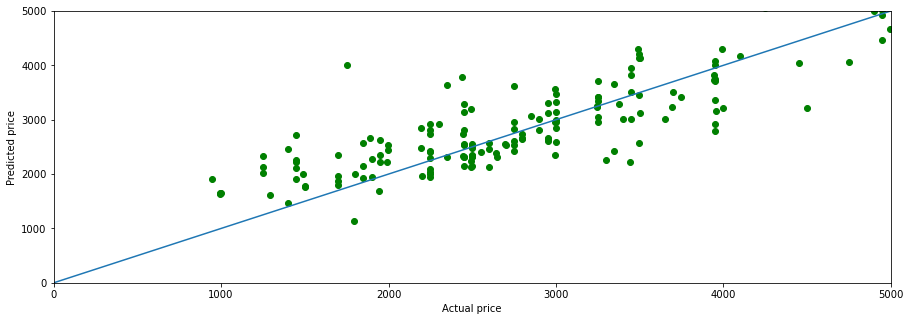

In [12]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.plot([0,5000], [0,5000])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [13]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']